this code is adapted from: https://www.kaggle.com/code/apapiu/regularized-linear-models
and https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
# from scipy.stats.stats import pearsonr 
from scipy.stats import pearsonr # changed Jake 21-03-2023
from scipy import stats
from scipy.stats import norm

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [506]:
train = pd.read_csv("train.csv") # data is saved in current folder
test = pd.read_csv("test.csv")

### Piece off the target variable
Target is sale price

In [507]:
train_target = train['SalePrice']
train.drop('SalePrice', axis=1, inplace=True)
print('number of null prices = ', train_target.isnull().sum())
print('number of zero prices = ', len(train_target[train_target == 0]))

number of null prices =  0
number of zero prices =  0


## Check target distribution

sale price skew =  1.8828757597682129
log sale price skew =  0.12133506220520406


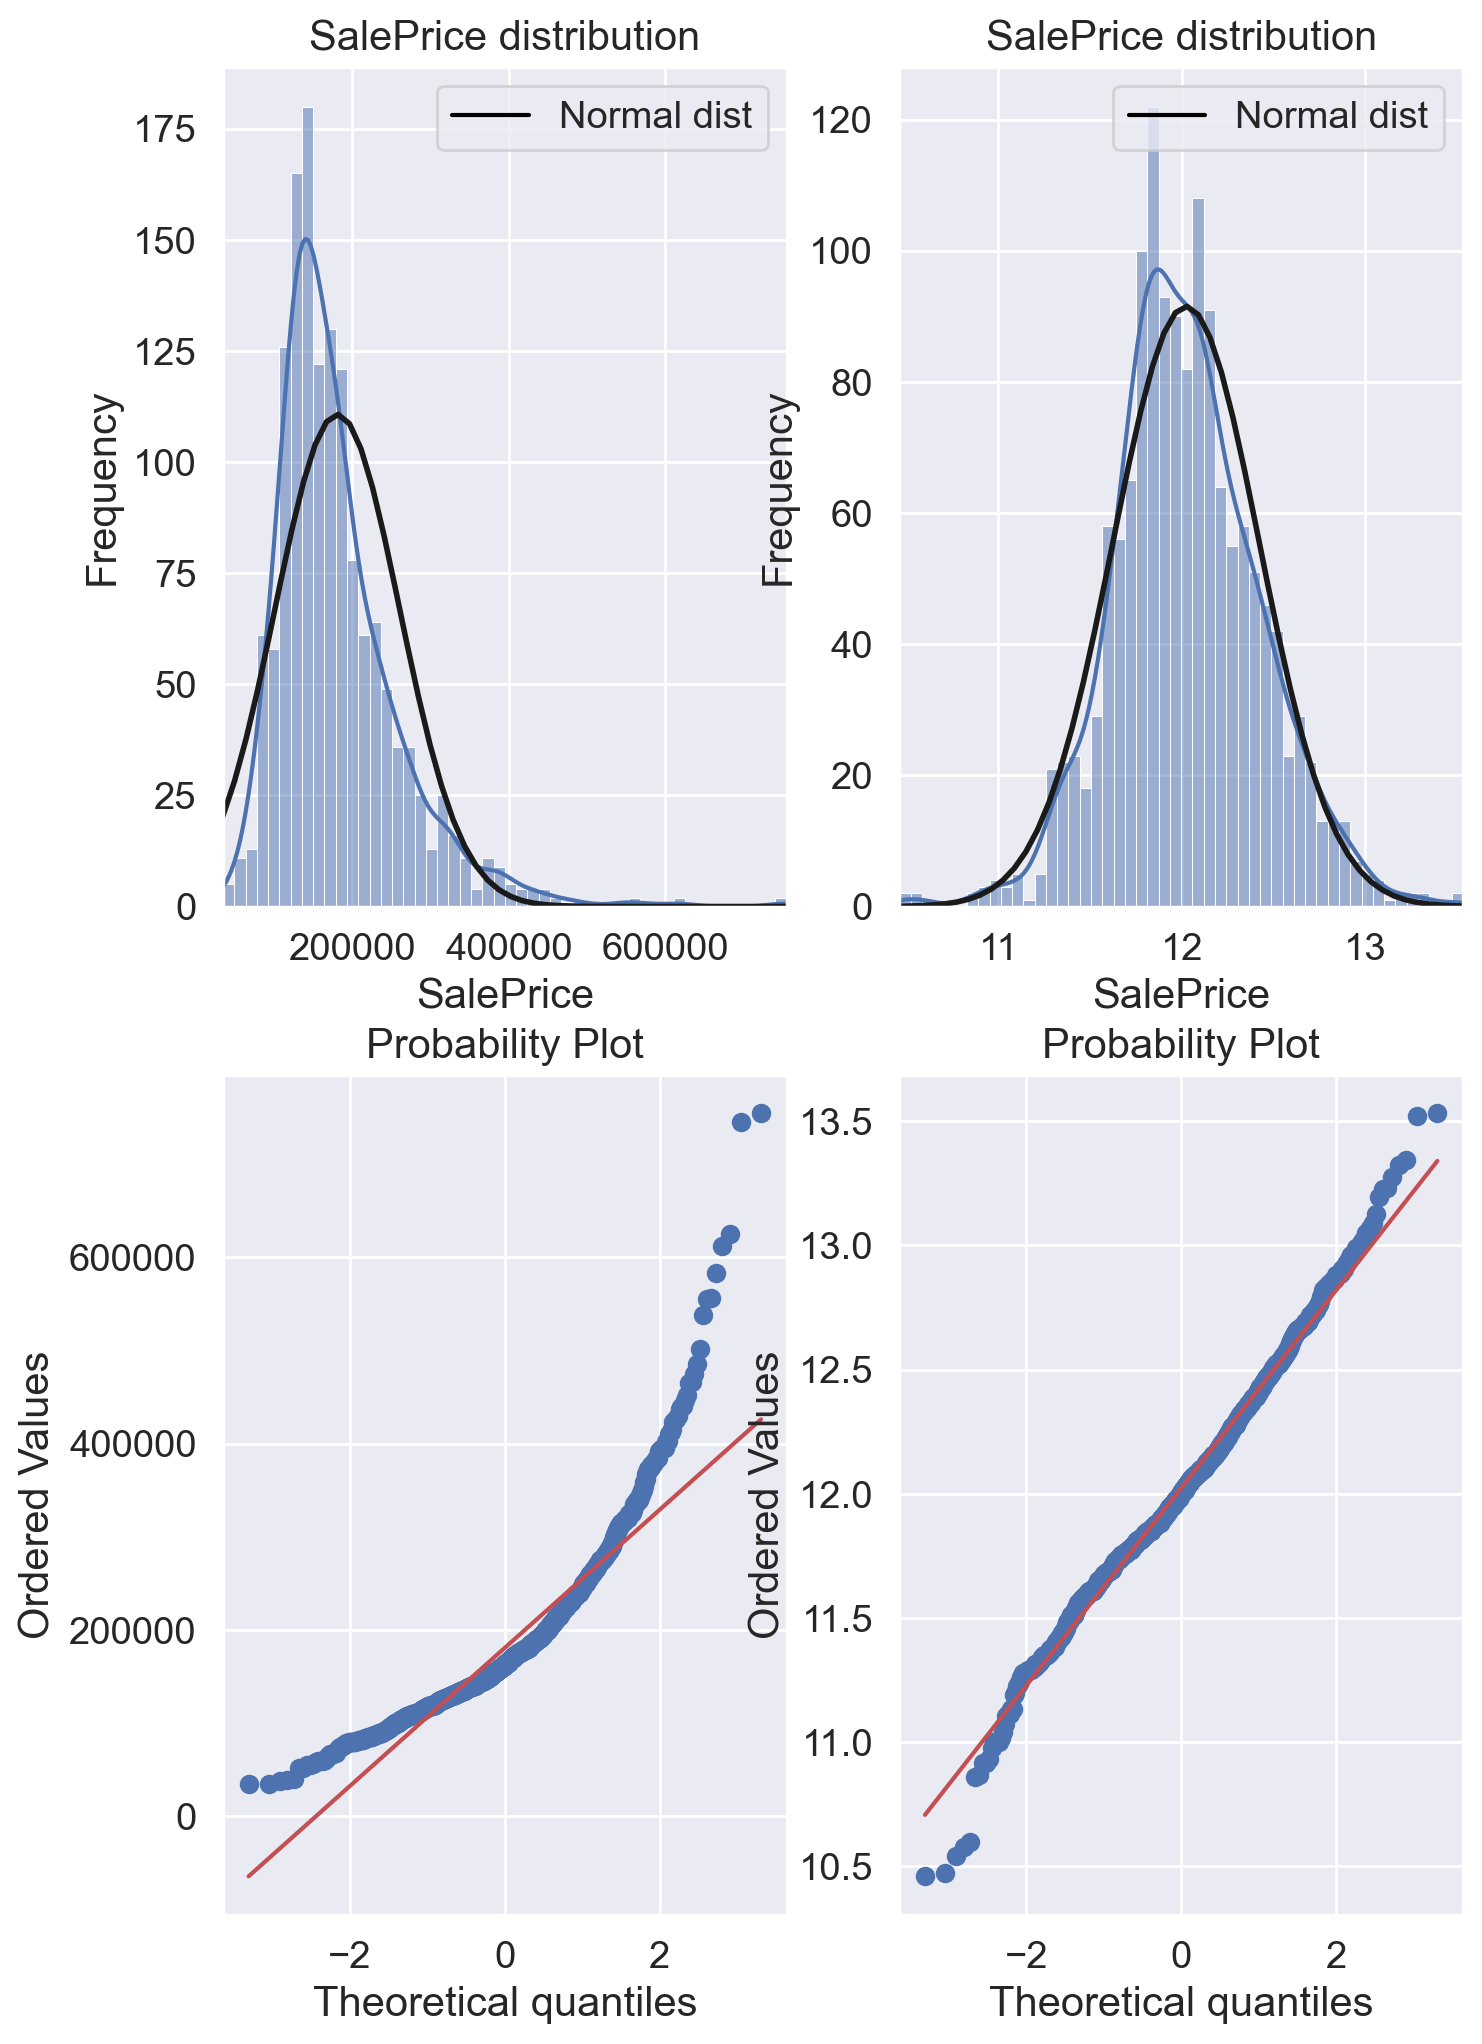

In [521]:
# log price
train_log_target = np.log(train_target)

fig, axes = plt.subplots(2, 2, figsize=(8,12))

for i in range(2):
    if i == 0:
        data_for_plot = train_target
    else:
        data_for_plot = train_log_target
                        
    # sale price distribution
    sns.histplot(data_for_plot, ax=axes[0, i], bins=50, 
                 binrange = (data_for_plot.min(), data_for_plot.max()), kde=True)
    axes[0, i].set_xlim(data_for_plot.min(), data_for_plot.max())

    (mu, sigma) = norm.fit(data_for_plot)
    # print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    x = np.linspace(data_for_plot.min(), data_for_plot.max(), 50)
    p = norm.pdf(x, mu, sigma) 
    p = (p / np.sum(p)) * len(data_for_plot)
    axes[0, i].plot(x, p, 'k', linewidth=2)
    # axes[0, i].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
    #                  loc='best')
    axes[0, i].legend(['Normal dist'], loc='best')
    leg = axes[0, i].get_legend()
    leg.legend_handles[0].set_color('black')
    axes[0, i].set_ylabel('Frequency')
    axes[0, i].set_title('SalePrice distribution')

    # sale price probability
    res = stats.probplot(data_for_plot, plot=axes[1,i]) # quantiles of theoretical normal distribution; best-fit line plotted

print('sale price skew = ', train_target.skew())
print('log sale price skew = ', train_log_target.skew())

## Target data is sorted!
Log transformed target is normally distributed, as we want. No zero or null values. We could perhaps search for outliers, but let's avoid that for now.

## Let's deal with our features
Let's calculate the proportion of null and zero values for each category. These may or may not be informative values, so we will need to take a look.

In [592]:
num_feats = len(train.columns)
num_houses = len(train)

train["MSSubClass"] = train["MSSubClass"].astype('object') # not numerical data, so convert the type

prop_missing = train.isnull().sum() / num_houses
prop_zero = train.isin([0]).sum(axis=0) / num_houses

print("proportion missing = \n", prop_missing[prop_missing.ne(0)])    

print("proportion zero = \n", prop_zero[prop_zero.ne(0)])   

proportion missing = 
 LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64
proportion zero = 
 MasVnrArea       0.589726
BsmtFinSF1       0.319863
BsmtFinSF2       0.885616
BsmtUnfSF        0.080822
TotalBsmtSF      0.025342
2ndFlrSF         0.567808
LowQualFinSF     0.982192
BsmtFullBath     0.586301
BsmtHalfBath     0.943836
FullBath         0.006164
HalfBath         0.625342
BedroomAbvGr     0.004110
KitchenAbvGr     0.000685
Fireplaces       0.472603
GarageCars       0.055479
GarageArea       0.055479
WoodDeckSF       0.521233
OpenPorchSF      0.449315

## one hot enocde the categorical features
Categorical features are all of type "object". One-hot encoding automatically deals with all the nulls. 

In [594]:
print(train.dtypes.unique())
categ_train = train.select_dtypes(include='object')
num_cat_features = len(categ_train.columns)
print('number of categorical features = ', num_cat_features)

categ_train_one_hot = pd.get_dummies(categ_train)

[dtype('int64') dtype('O') dtype('float64')]
number of categorical features =  44


C:\Users\Jake\AppData\Local\Temp\ipykernel_21924\1583547753.py:6: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  categ_train_one_hot = pd.get_dummies(categ_train)


## But we still need to deal with any nulls in our numerical features
Nulls become 0

In [604]:
nume_train = train.select_dtypes(exclude='object')
nume_train = nume_train.drop(columns=['Id'])
num_nume_features = len(nume_train.columns)
print('number of numeric features = ', num_nume_features)

nume_train = nume_train.fillna(0)



number of numeric features =  35


## Then calculate and examine skew 

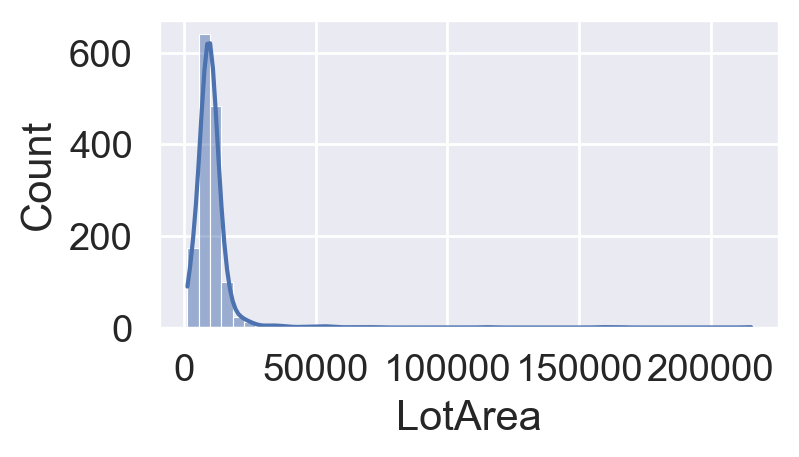

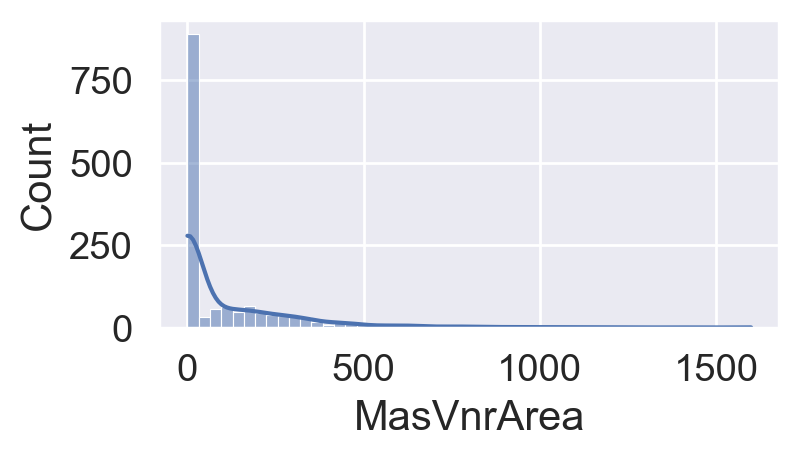

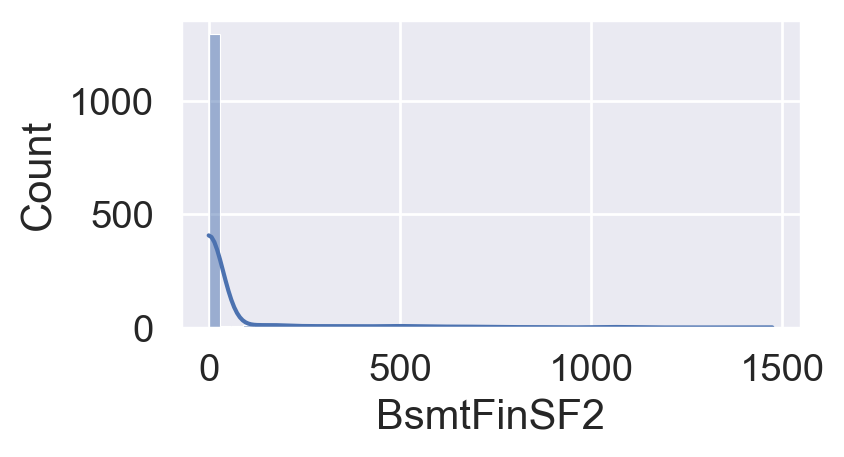

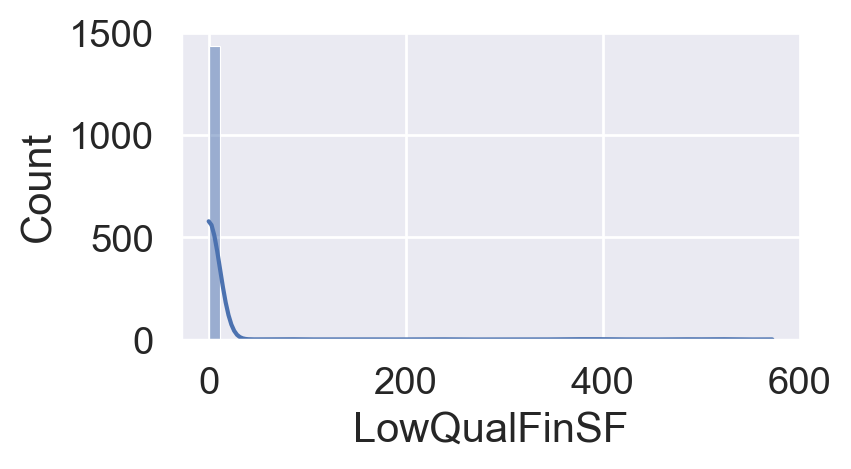

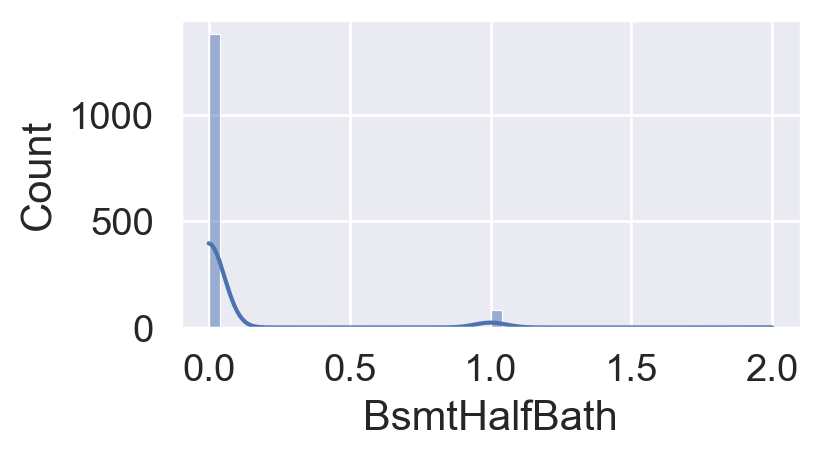

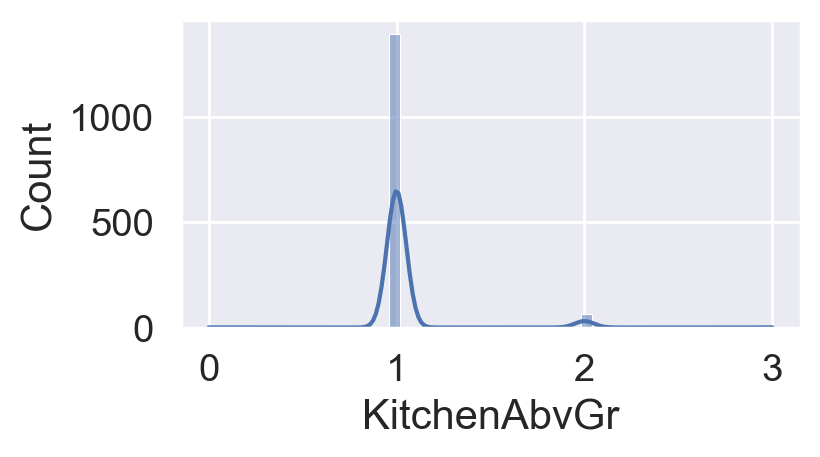

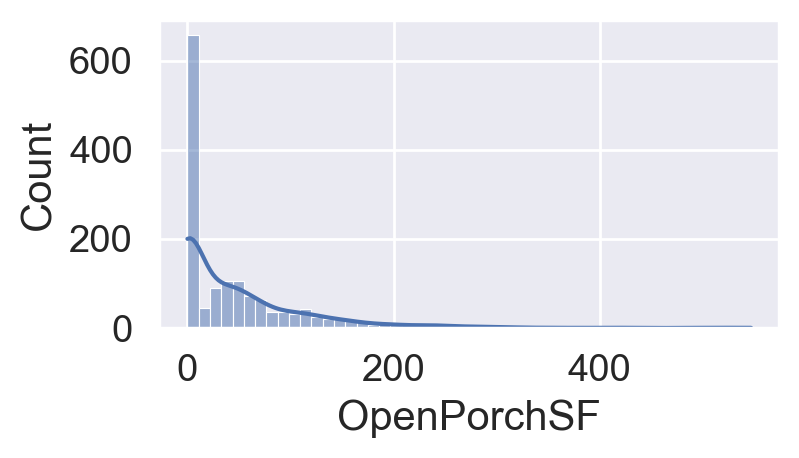

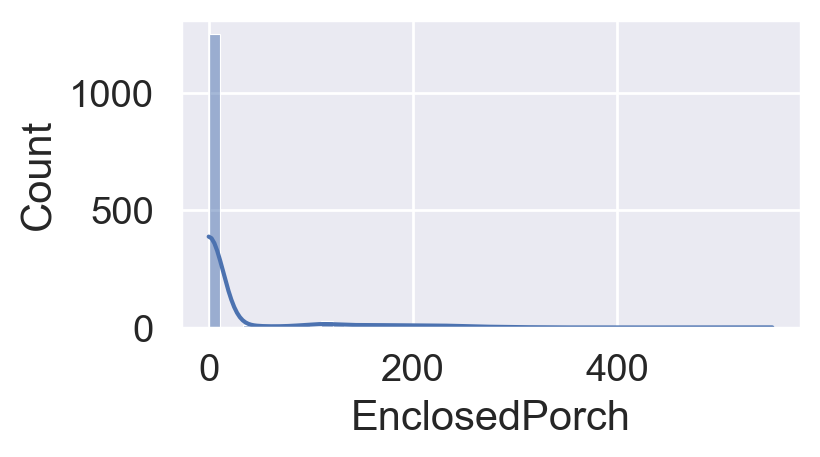

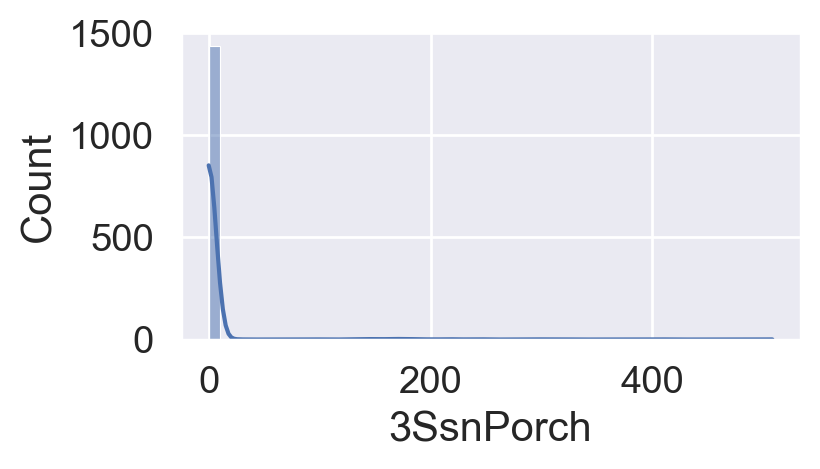

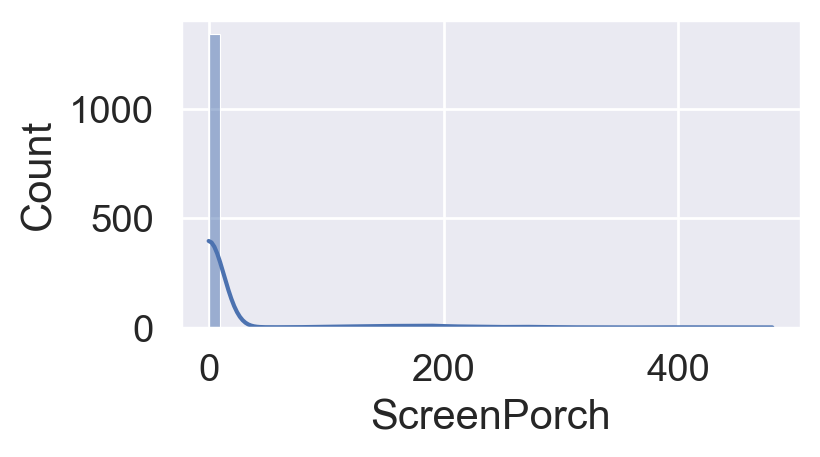

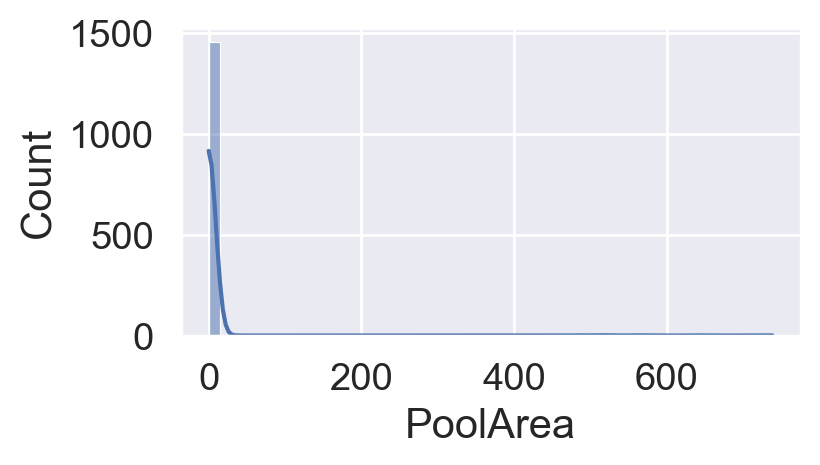

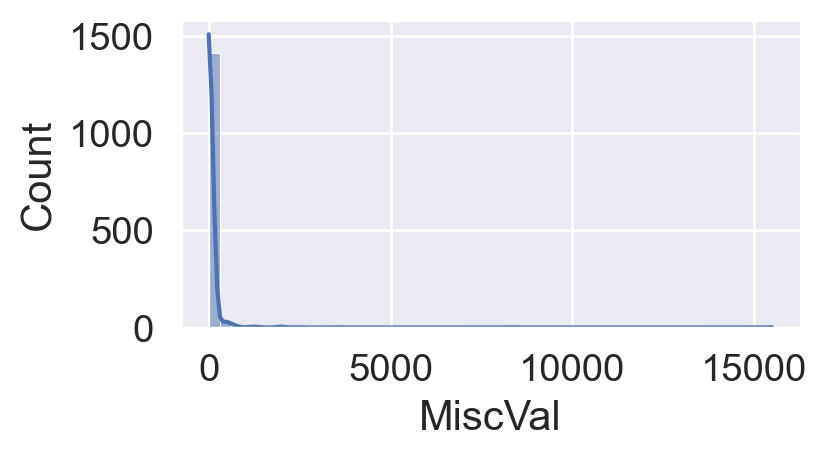

In [635]:
skewed_feats = nume_train.skew(axis=0)
pos_skewed = skewed_feats[skewed_feats > 2]
neg_skewed = skewed_feats[skewed_feats < -2]
# let's look at the highly skewed features to see what we should do

for indx, vals in pos_skewed.items():
    _ = plt.figure(figsize=(4,2))
    _ = sns.histplot(nume_train[indx], bins=50, binrange = (nume_train[indx].min(), nume_train[indx].max()), kde=True);
    #axes.set_xlim(nume_train[indx].min(), nume_train[indx].max())  

Looking at these plots, only LotArea looks like it would benefit from log normalization. The other plots, with there large number of zero values can't be transformed into anything resembling a normal distribution. 

Everything assumed to be normal (or transformed to be normal, in the case of LotArea) will be z-scored. The other features shown above will instead be divided by their max value to squash them between 0 and 1.

# For missing values

Need to examine data manually to determine what missing values mean. 

LotFrontage: ENCODE AS ALL ZEROS\
Alley: ENCODE AS ALL ZEROS\
MasVnrType: ENCODE AS ALL ZEROS\
MasVnrArea: ENCODE AS ZERO\
BsmtQual: ENCODE AS ALL ZEROS\
BsmtCond: ENCODE AS ALL ZEROS\
BsmtExposure: ENCODE AS ALL ZEROS\
BsmtFinType1: ENCODE AS ALL ZEROS\
BsmtFinType2: ENCODE AS ALL ZEROS\
Electrical: ENCODE AS ALL ZEROS\
FireplaceQu: ENCODE AS ALL ZEROS\
GarageType: ENCODE AS ALL ZEROS\
GarageYrBlt: REMOVE CATEGORY (REDUNDANT W GARAGETYPE)\
GarageFinish: ENCODE AS ALL ZEROS\
GarageQual: ENCODE AS ALL ZEROS\
GarageCond: ENCODE AS ALL ZEROS\
PoolQC: ENCODE AS ALL ZEROS\
Fence: ENCODE AS ALL ZEROS\
MiscFeature: ENCODE AS ALL ZEROS

For now, let's split off our categorical features and one hot-encode them. All the nulls will be encoded as all zeros. 

In [520]:
print("proportion  = \n", prop_zero[prop_zero.ne(0)]) 

proportion  = 
 MasVnrArea       0.589726
BsmtFinSF1       0.319863
BsmtFinSF2       0.885616
BsmtUnfSF        0.080822
TotalBsmtSF      0.025342
2ndFlrSF         0.567808
LowQualFinSF     0.982192
BsmtFullBath     0.586301
BsmtHalfBath     0.943836
FullBath         0.006164
HalfBath         0.625342
BedroomAbvGr     0.004110
KitchenAbvGr     0.000685
Fireplaces       0.472603
GarageCars       0.055479
GarageArea       0.055479
WoodDeckSF       0.521233
OpenPorchSF      0.449315
EnclosedPorch    0.857534
3SsnPorch        0.983562
ScreenPorch      0.920548
PoolArea         0.995205
MiscVal          0.964384
dtype: float64


# Deal with zeros
For now, we'll do nothing. Later, if necessary, we can remove columns with very large proportions of zeros, or perhaps convert some of these numerical features to binary categorical features

## Features Engineering

First, look at the training data in a spread sheet to determine which types of data can be exlcuded. 

Alley: most values are NA, so this won't add much to the model.\
BsmtFinType2: most values are 0\
LowQualFinSF: most values are 0\
PavedDrive: most values are Y\
3SsnPorch: most vals are 0\
ScreenPorch: most vals are 0\
PoolArea: most vals are 0\
PoolQC: most vals are NA\
MiscFeature: most vals are NA\
MiscVal: most vals are 0

MasVnrArea: many 0s, we can probably make binary (i.e. 0 or 1)

These can all be removed, but let's look at correlations first; it's possible that the features listed above will be excluded from further analysis on the basis of low correlations with LogSalePrice.

<Axes: >

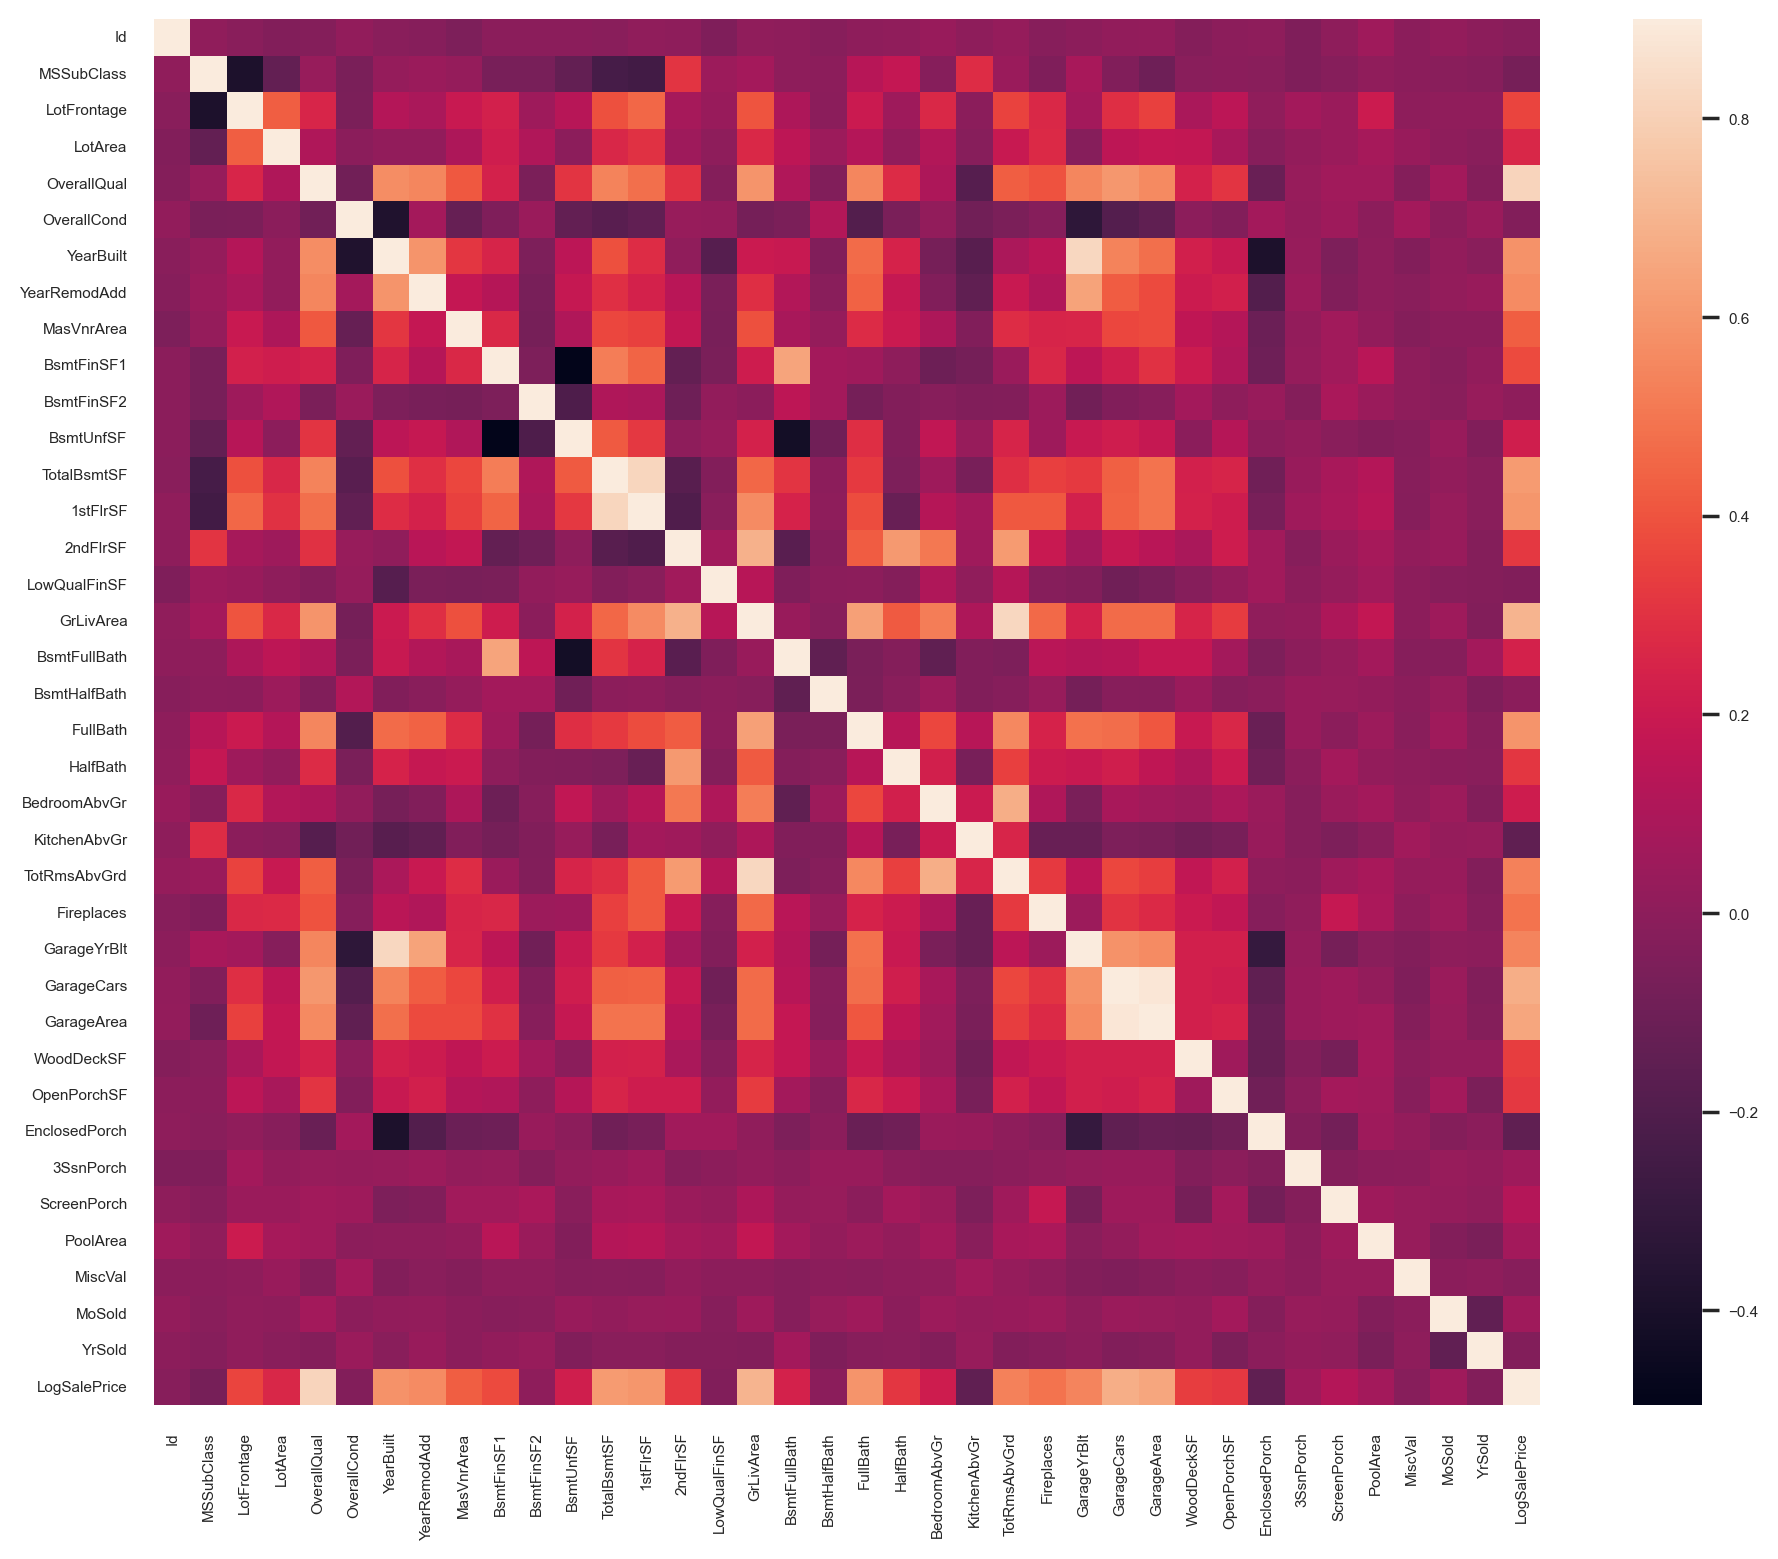

In [238]:
#train.drop(columns=['SalePrice'], inplace=True)
corrmat = train.corr(numeric_only=True)
plt.subplots(figsize=(12,9))
sns.set(font_scale=.5)
sns.heatmap(corrmat, vmax=0.9, square=True)

### Let's look at highest 20 correlations

Index(['LogSalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd',
       'GarageYrBlt', 'TotRmsAbvGrd', 'Fireplaces', 'MasVnrArea', 'BsmtFinSF1',
       'LotFrontage', 'WoodDeckSF', 'OpenPorchSF', '2ndFlrSF', 'HalfBath'],
      dtype='object')
(20, 20)


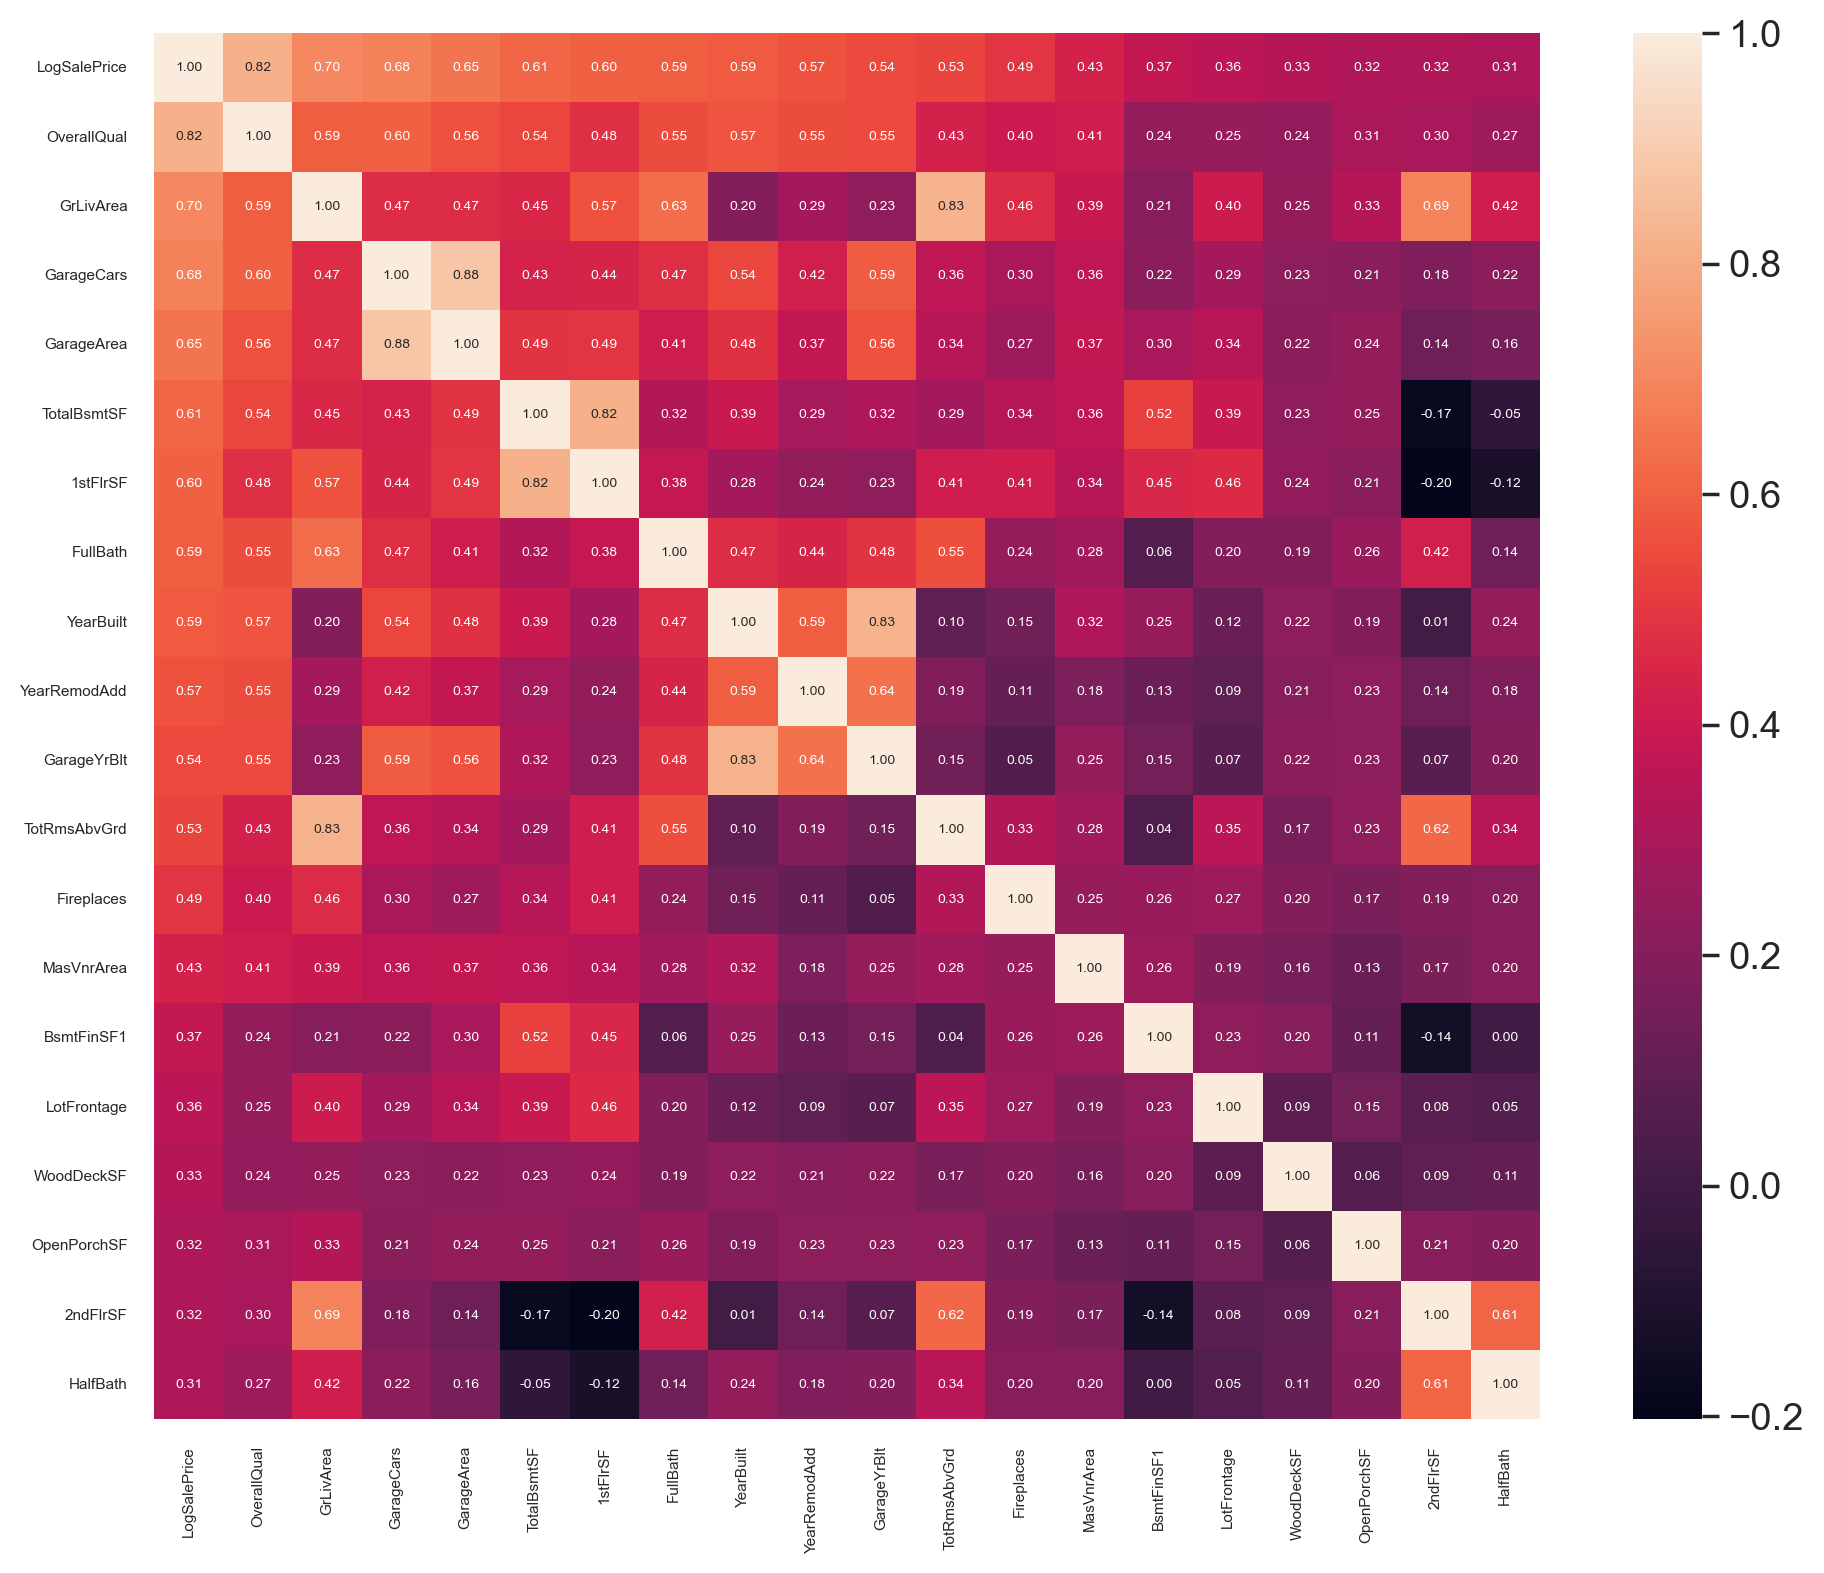

In [239]:
k = 20 #number of variables for heatmap
numeric_features = corrmat.nlargest(k, 'LogSalePrice')['LogSalePrice'].index # note: LogSalePrice included, so remove later
print(numeric_features)
# cm = np.corrcoef(train[numeric_features].values.T)

corrmat = train[numeric_features].corr(numeric_only=True)
print(corrmat.shape)
plt.subplots(figsize=(12,9))

# sns.heatmap(corrmat, vmax=0.9, square=True)
sns.set(font_scale=1.25)
hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 5}, yticklabels=numeric_features.values, xticklabels=numeric_features.values)
# plt.show()



### verify that our numeric features are not amongst those we thought should be excluded

first, let's split off LogSalePrice

In [310]:
train_log_price = train['LogSalePrice'];

features_to_drop = ['Alley', 'BsmtFinType2', 'LowQualFinSF', 'PavedDrive', '3SsnPorch', 
               'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscFeature', 'MiscVal', 'MasVnrArea']

more_features_to_drop = set(features_to_drop) & set(numeric_features.to_list()) # this produces an empty set, so we're good


In [337]:
new_train_numeric = train.copy()
new_train_numeric = new_train_numeric[numeric_features]
new_train_numeric.drop(columns='LogSalePrice', inplace=True)
new_train_numeric.drop(columns=more_features_to_drop, inplace=True)
new_train_numeric.head(10)

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,GarageYrBlt,TotRmsAbvGrd,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,OpenPorchSF,2ndFlrSF,HalfBath
0,7,1710,2,548,856,856,2,2003,2003,2003.0,8,0,706,65.0,0,61,854,1
1,6,1262,2,460,1262,1262,2,1976,1976,1976.0,6,1,978,80.0,298,0,0,0
2,7,1786,2,608,920,920,2,2001,2002,2001.0,6,1,486,68.0,0,42,866,1
3,7,1717,3,642,756,961,1,1915,1970,1998.0,7,1,216,60.0,0,35,756,0
4,8,2198,3,836,1145,1145,2,2000,2000,2000.0,9,1,655,84.0,192,84,1053,1
5,5,1362,2,480,796,796,1,1993,1995,1993.0,5,0,732,85.0,40,30,566,1
6,8,1694,2,636,1686,1694,2,2004,2005,2004.0,7,1,1369,75.0,255,57,0,0
7,7,2090,2,484,1107,1107,2,1973,1973,1973.0,7,2,859,NaN,235,204,983,1
8,7,1774,2,468,952,1022,2,1931,1950,1931.0,8,2,0,51.0,90,0,752,0
9,5,1077,1,205,991,1077,1,1939,1950,1939.0,5,2,851,50.0,0,4,0,0


## Check how much data is missing from these features


LotFrontage has many NA values. These should be 0 (i.e. no lot frontage)

In [343]:
new_train_numeric["LotFrontage"].fillna(value=0, inplace=True)

## Measure skewness in 

In [344]:
# compute skewness
# skewed_feats = new_train_numeric.apply(lambda x: skew(x.dropna()))

skewed_feats = new_train_numeric.skew(axis=0)
print(skewed_feats)

OverallQual     0.216944
GrLivArea       1.366560
GarageCars     -0.342549
GarageArea      0.179981
TotalBsmtSF     1.524255
1stFlrSF        1.376757
FullBath        0.036562
YearBuilt      -0.613461
YearRemodAdd   -0.503562
GarageYrBlt    -0.649415
TotRmsAbvGrd    0.676341
Fireplaces      0.649565
BsmtFinSF1      1.685503
LotFrontage     0.267822
WoodDeckSF      1.541376
OpenPorchSF     2.364342
2ndFlrSF        0.813030
HalfBath        0.675897
dtype: float64


## plot out features that are skewed and transform them

In [345]:
skewed_feats = skewed_feats[abs(skewed_feats) > 1]
print(skewed_feats)

GrLivArea      1.366560
TotalBsmtSF    1.524255
1stFlrSF       1.376757
BsmtFinSF1     1.685503
WoodDeckSF     1.541376
OpenPorchSF    2.364342
dtype: float64


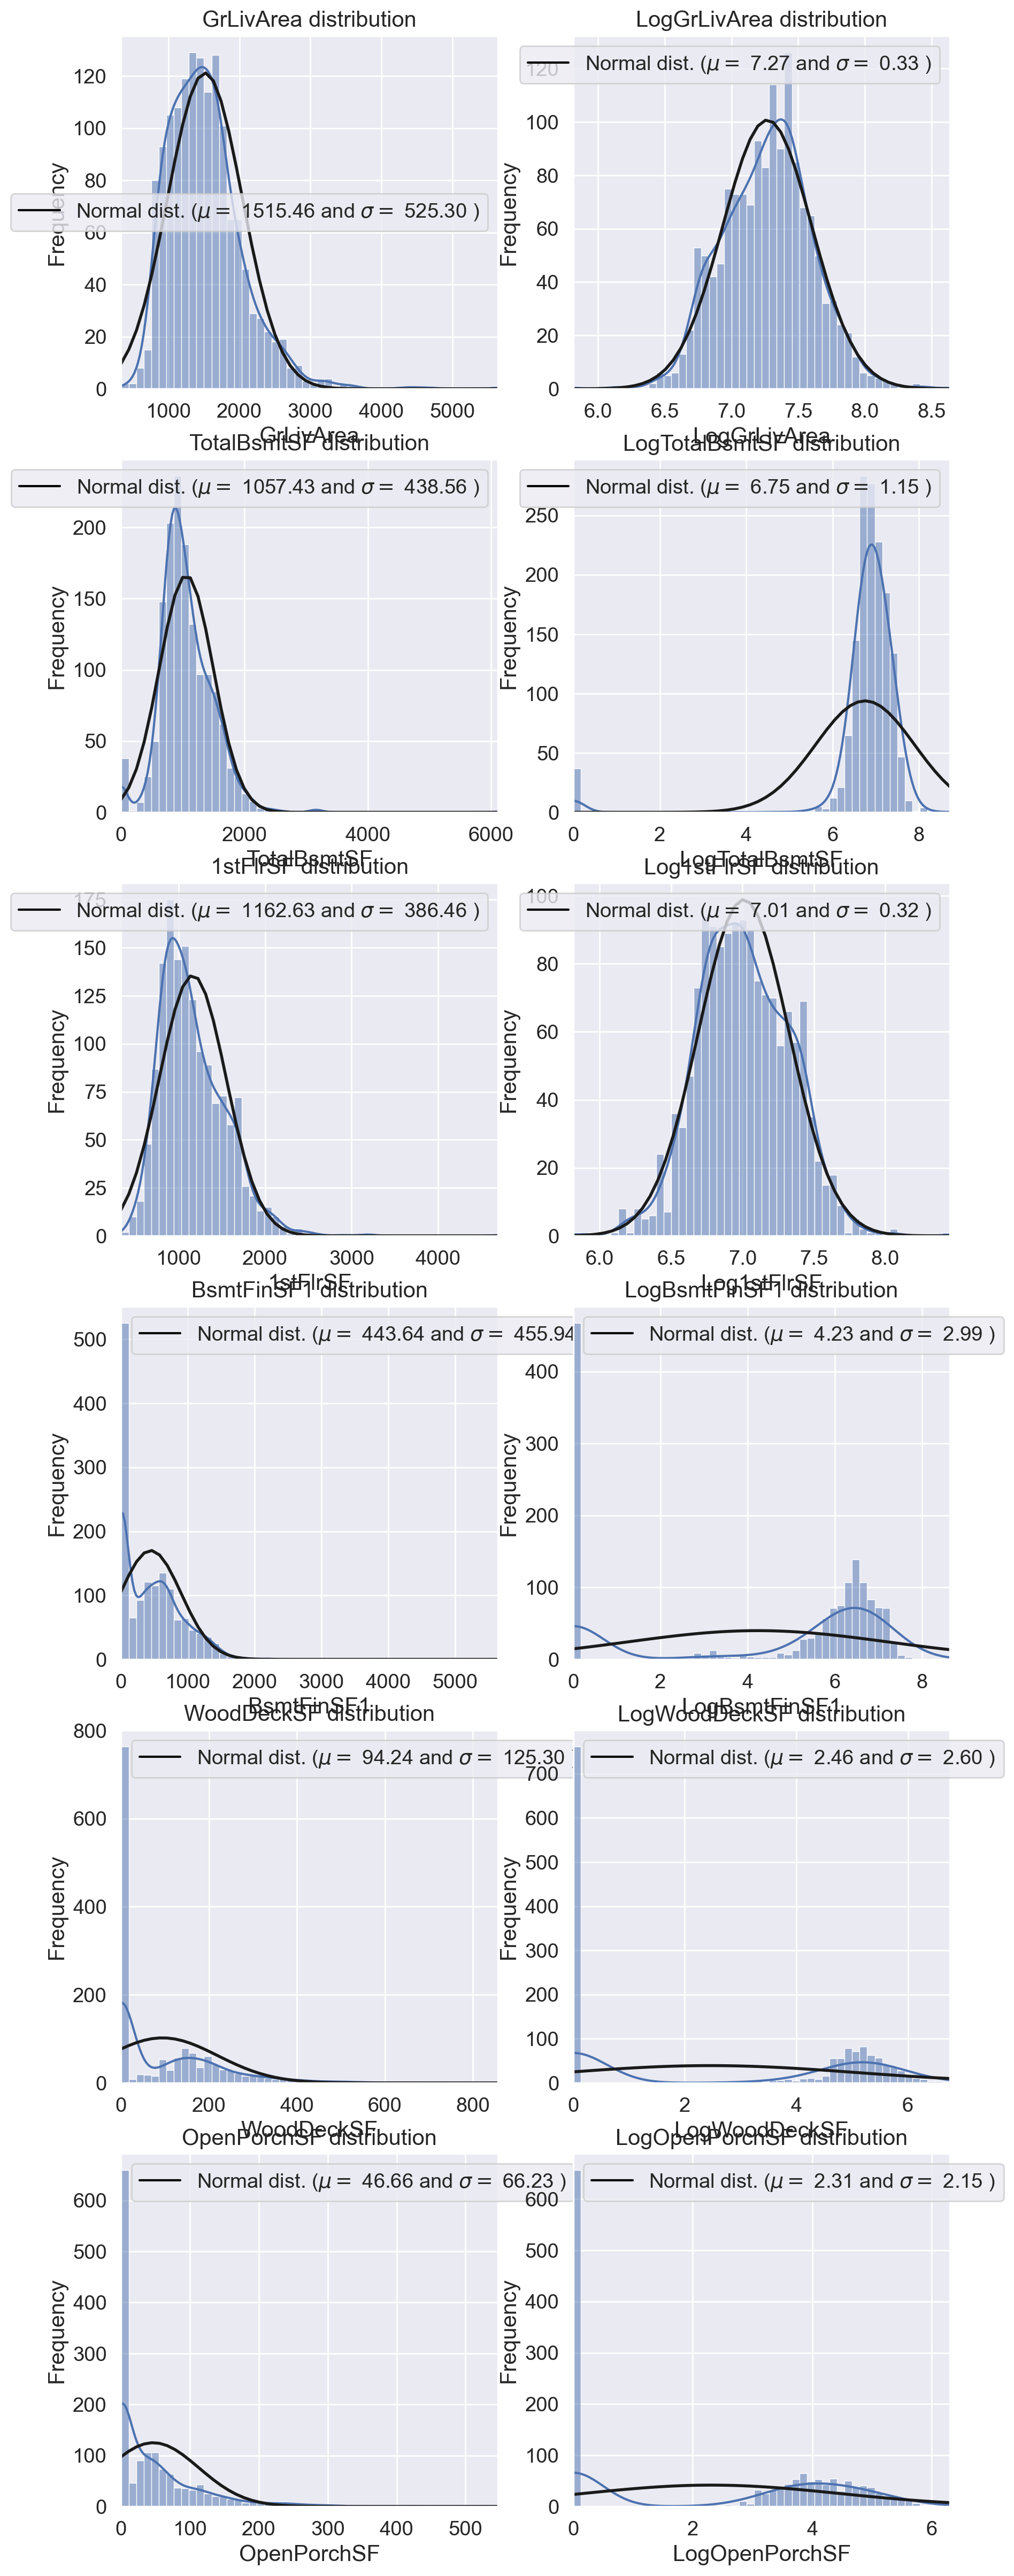

In [348]:
# 8 skewed features in total
fig, axes = plt.subplots(6, 2, figsize=(10,30))

for i in range(6):
    temp_feat = skewed_feats.index[i]
    sns.histplot(train[temp_feat], ax=axes[i, 0], bins=50, 
             binrange = (train[temp_feat].min(), train[temp_feat].max()), kde=True)
    axes[i, 0].set_xlim(train[temp_feat].min(), train[temp_feat].max())

    (mu, sigma) = norm.fit(train[temp_feat])
    # print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    x = np.linspace(train[temp_feat].min(), train[temp_feat].max(), 50)
    p = norm.pdf(x, mu, sigma) 
    p = (p / np.sum(p)) * len(train[temp_feat].index)
    axes[i, 0].plot(x, p, 'k', linewidth=2)
    axes[i, 0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                      loc='best')
    leg = axes[i, 0].get_legend()
    leg.legend_handles[0].set_color('black')
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].set_title(temp_feat + ' distribution')

    # log price
    logFeat = "Log" + temp_feat
    train[logFeat] = np.log1p(train[temp_feat])
    log_plot = sns.histplot(train[logFeat], ax=axes[i,1], bins=50, 
             binrange = (train[logFeat].min(), train[logFeat].max()), kde=True);
    axes[i, 1].set_xlim(train[logFeat].min(), train[logFeat].max());

    (mu, sigma) = norm.fit(train[logFeat])
    x = np.linspace(train[logFeat].min(), train[logFeat].max(), 50)
    p = norm.pdf(x, mu, sigma) 
    p = (p / np.sum(p)) * len(train[logFeat].index)
    axes[i, 1].plot(x, p, 'k', linewidth=2)
    axes[i, 1].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                  loc='best')
    leg = axes[i, 1].get_legend()
    leg.legend_handles[0].set_color('black')
    axes[i, 1].set_ylabel('Frequency')
    axes[i, 1].set_title(logFeat + ' distribution')


# sale price probability
#res = stats.probplot(train['SalePrice'], plot=axes[1,0]) # quantiles of theoretical normal distribution; best-fit line plotted

#res = stats.probplot(train['LogSalePrice'], plot=axes[1,1])

Log transformation made the 1st and 3rd features more normal, but it doesn't work well when there are lots of 0 values. For now, let's not bother using log transformed data.

We could consider making the bottom 3 categories into binary categories (0 = 0, everything else = 1)

# Categorical Features

In [354]:
train.select_dtypes(include=['object'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [357]:
mszoning = pd.get_dummies(train["MSZoning"])
mszoning.head()

,C (all),FV,RH,RL,RM
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [358]:
street = pd.get_dummies(train["Street"])
street.head()

,Grvl,Pave
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
